In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [2]:
df= pd.read_csv("translated1.csv")

In [3]:
df

,Unnamed: 0,review_date,rating,mrp,country,product_id,trans_review
0,0,2023-11-20,5,79999,India,14900K,Just upgraded from i5 9400f to i9 14900k and s...
1,1,2024-03-28,1,79999,India,14900K,I don't liked the price of it . I Also don't l...
2,2,2024-05-16,5,45000,Spain,14600KF,Good processor that gives you to be able to pl...
3,3,2024-02-23,5,73700,Japan,14900KF,It's early to do anything!As expected!I am ver...
4,4,2024-03-05,5,79999,Canada,14900K,Good decision for my computer
...,...,...,...,...,...,...,...
1473,1473,2024-04-03,1,59100,the United States,14700K,"overall intel is great for a work station, HOW..."
1474,1474,2024-05-03,1,59100,the United States,14700K,I have written a couple of dozen reviews on Am...
1475,1475,2024-01-06,5,59100,the United States,14700K,Great cpu for gaming. No regrets
1476,1476,2024-01-21,5,59100,the United States,14700K,Just Great


In [4]:
#VADER approach
sia = SentimentIntensityAnalyzer()

In [5]:
#testing
sia.polarity_scores("I don't liked the price of it . I Also don't liked the performance of it . Rather you can purchase i9 13th generation")

{'neg': 0.206, 'neu': 0.794, 'pos': 0.0, 'compound': -0.5667}

In [6]:
# Run the polarity score on the entire dataset
scores = {}
for i in range(len(df)):
    text = df['trans_review'].iloc[i]
    scores[i] = sia.polarity_scores(text)

In [8]:
vaders = pd.DataFrame(scores).T
vaders

,neg,neu,pos,compound
0,0.013,0.775,0.212,0.9818
1,0.206,0.794,0.000,-0.5667
2,0.000,0.739,0.261,0.6486
3,0.000,0.685,0.315,0.5686
4,0.000,0.580,0.420,0.4404
...,...,...,...,...
1473,0.080,0.824,0.096,0.4972
1474,0.086,0.868,0.046,-0.8181
1475,0.398,0.254,0.347,0.1027
1476,0.000,0.196,0.804,0.6249


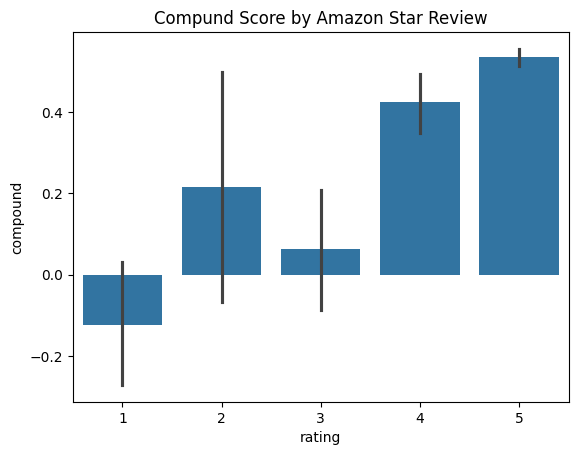

In [9]:
#verifying how accurate the result is by plotting it against the rating given by the users
ax = sns.barplot(data=vaders, x=df['rating'], y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()


In [10]:
#except for 3 star rated objects the compound review seems to be valid and is higher for high rated products
df['rating'].value_counts()
#this might be because of less available data for certain reviews

rating
5    1185
4     175
3      51
1      50
2      17
Name: count, dtype: int64

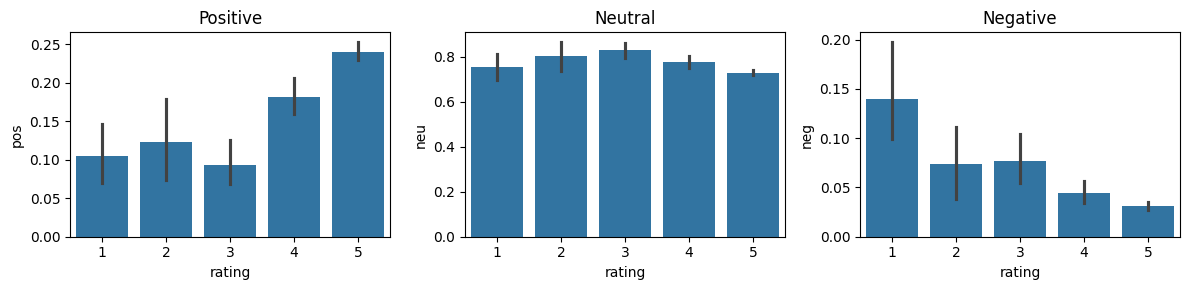

In [11]:
#other scores
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x=df['rating'], y='pos', ax=axs[0])
sns.barplot(data=vaders, x=df['rating'], y='neu', ax=axs[1])
sns.barplot(data=vaders, x=df['rating'], y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [12]:
#out of the above 3 , negative scores seems the best, postive score score also seems valid
#we may consider that the person's review and the rating do not match in some cases
import warnings
warnings.filterwarnings('ignore')
df_vaders=pd.DataFrame()
df_vaders=df
df_vaders['sentiment']=""
for i in range(len(vaders)):
    if  vaders['compound'].iloc[i]>0.1:
        df_vaders['sentiment'].iloc[i]='positive'
    elif vaders['compound'].iloc[i]< -0.1:
        df_vaders['sentiment'].iloc[i]='negative'
    else:
        df_vaders['sentiment'].iloc[i]='neutral'
df_vaders.head()

,Unnamed: 0,review_date,rating,mrp,country,product_id,trans_review,sentiment
0,0,2023-11-20,5,79999,India,14900K,Just upgraded from i5 9400f to i9 14900k and s...,positive
1,1,2024-03-28,1,79999,India,14900K,I don't liked the price of it . I Also don't l...,negative
2,2,2024-05-16,5,45000,Spain,14600KF,Good processor that gives you to be able to pl...,positive
3,3,2024-02-23,5,73700,Japan,14900KF,It's early to do anything!As expected!I am ver...,positive
4,4,2024-03-05,5,79999,Canada,14900K,Good decision for my computer,positive


In [13]:
#using Roberata model to evaluate for sentiment classification
#pretrained model
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [14]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL) 

In [15]:
encoded_text = tokenizer("I don't liked the price of it . I Also don't liked the performance of it . Rather you can purchase i9 13th generation", return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.9449626, 'roberta_neu': 0.050749753, 'roberta_pos': 0.004287674}


In [16]:
encoded_text = tokenizer("The game falls as reputation.However, the problem is solved by setting the BIOS and graphics, but it is not for those who are at least for the first time.If you still want it, let's study the settings well.", return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.4028619, 'roberta_neu': 0.47749788, 'roberta_pos': 0.11964024}


In [17]:
encoded_text = tokenizer("Consumption up to 320 W too dear value for money", return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.114151485, 'roberta_neu': 0.80705863, 'roberta_pos': 0.07878987}


In [18]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [19]:
roberta_scores={}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['trans_review']
        myid = row['Unnamed: 0']
        roberta_result = polarity_scores_roberta(text)
        roberta_scores[myid] = roberta_result
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/1478 [00:00<?, ?it/s]

Broke for id 8
Broke for id 20
Broke for id 29
Broke for id 34
Broke for id 956
Broke for id 1209
Broke for id 1275
Broke for id 1294


In [25]:
#the model broke for 8,20,29,34,956,1209,1275,1294 , adding the scores here manually based on the review stars
for i in [8,20,29,34,956,1209,1275,1294]:
    rating= df['rating'].iloc[i]
    if rating == 3 :
        roberta_scores[i]={'roberta_neg': 0.05,
  'roberta_neu': 0.9,
  'roberta_pos': 0.05}
    elif rating < 3:
        roberta_scores[i]={'roberta_neg': 0.9,
  'roberta_neu': 0.05,
  'roberta_pos': 0.05}
    else:
        roberta_scores[i]={'roberta_neg': 0.05,
  'roberta_neu': 0.05,
  'roberta_pos': 0.9}


In [28]:
roberta_scores

{0: {'roberta_neg': 0.0055599194,
  'roberta_neu': 0.08085501,
  'roberta_pos': 0.913585},
 1: {'roberta_neg': 0.9449626,
  'roberta_neu': 0.050749753,
  'roberta_pos': 0.004287674},
 2: {'roberta_neg': 0.00811849,
  'roberta_neu': 0.18509339,
  'roberta_pos': 0.80678815},
 3: {'roberta_neg': 0.0037714723,
  'roberta_neu': 0.027059175,
  'roberta_pos': 0.9691694},
 4: {'roberta_neg': 0.006655607,
  'roberta_neu': 0.081752196,
  'roberta_pos': 0.9115922},
 5: {'roberta_neg': 0.010467882,
  'roberta_neu': 0.13404486,
  'roberta_pos': 0.8554873},
 6: {'roberta_neg': 0.21162629,
  'roberta_neu': 0.4422051,
  'roberta_pos': 0.34616858},
 7: {'roberta_neg': 0.0077183326,
  'roberta_neu': 0.1984795,
  'roberta_pos': 0.7938022},
 8: {'roberta_neg': 0.05, 'roberta_neu': 0.05, 'roberta_pos': 0.9},
 9: {'roberta_neg': 0.026210846,
  'roberta_neu': 0.64732116,
  'roberta_pos': 0.32646796},
 10: {'roberta_neg': 0.0016990142,
  'roberta_neu': 0.023894891,
  'roberta_pos': 0.9744061},
 11: {'roberta_

In [34]:
robert= pd.DataFrame(roberta_scores).T
robert.head(10)

,roberta_neg,roberta_neu,roberta_pos
0,0.005560,0.080855,0.913585
1,0.944963,0.050750,0.004288
2,0.008118,0.185093,0.806788
3,0.003771,0.027059,0.969169
4,0.006656,0.081752,0.911592
5,0.010468,0.134045,0.855487
6,0.211626,0.442205,0.346169
7,0.007718,0.198480,0.793802
8,0.050000,0.050000,0.900000
9,0.026211,0.647321,0.326468


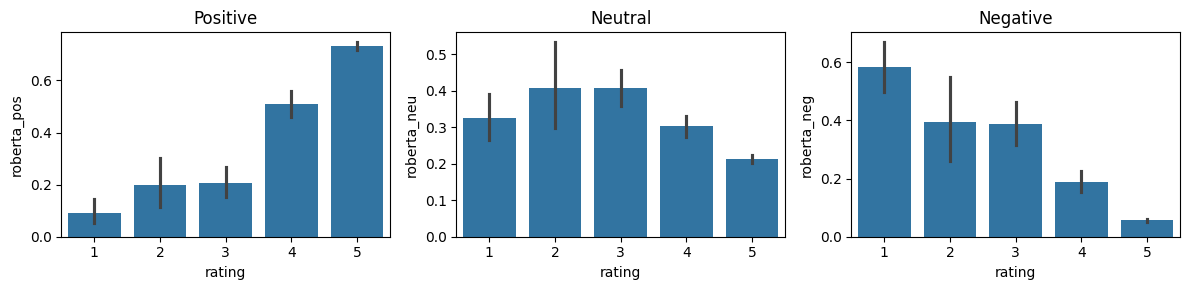

In [38]:
#scores of roBERTa model 
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=robert, x=df['rating'], y='roberta_pos', ax=axs[0])
sns.barplot(data=robert, x=df['rating'], y='roberta_neu', ax=axs[1])
sns.barplot(data=robert, x=df['rating'], y='roberta_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [45]:
import warnings
warnings.filterwarnings('ignore')
df_roberta=df
df_roberta['sentiment']=""

for i in range(len(robert)):
    maxi= max( robert.iloc[i])
    if  maxi == robert['roberta_pos'].iloc[i]:
        df_roberta['sentiment'].iloc[i]='positive'
    elif maxi == robert['roberta_neg'].iloc[i]:
        df_roberta['sentiment'].iloc[i]='negative'
    else:
        df_roberta['sentiment'].iloc[i]='neutral'
df_roberta.head()

,Unnamed: 0,review_date,rating,mrp,country,product_id,trans_review,sentiment
0,0,2023-11-20,5,79999,India,14900K,Just upgraded from i5 9400f to i9 14900k and s...,positive
1,1,2024-03-28,1,79999,India,14900K,I don't liked the price of it . I Also don't l...,negative
2,2,2024-05-16,5,45000,Spain,14600KF,Good processor that gives you to be able to pl...,positive
3,3,2024-02-23,5,73700,Japan,14900KF,It's early to do anything!As expected!I am ver...,positive
4,4,2024-03-05,5,79999,Canada,14900K,Good decision for my computer,positive


In [53]:
df_vaders_roberta_sentiments =pd.DataFrame()
df_vaders_roberta_sentiments['vaders'] = df_vaders['sentiment'].apply(lambda sentiment: 1 if sentiment == 'positive' else (0 if sentiment == 'neutral' else (-1 if sentiment == 'negative' else None)))
df_vaders_roberta_sentiments['roberta'] = df_roberta['sentiment'].apply(lambda sentiment: 1 if sentiment == 'positive' else (0 if sentiment == 'neutral' else (-1 if sentiment == 'negative' else None)))
df_vaders_roberta_sentiments['rating_classification']= df['rating'].apply(lambda rating: 1 if rating >3  else (-1 if rating < 3 else 0 ))

In [54]:
df_vaders_roberta_sentiments

,vaders,roberta,rating_classification
0,1,1,1
1,-1,-1,-1
2,1,1,1
3,1,1,1
4,1,1,1
...,...,...,...
1473,-1,-1,-1
1474,-1,-1,-1
1475,1,1,1
1476,1,1,1


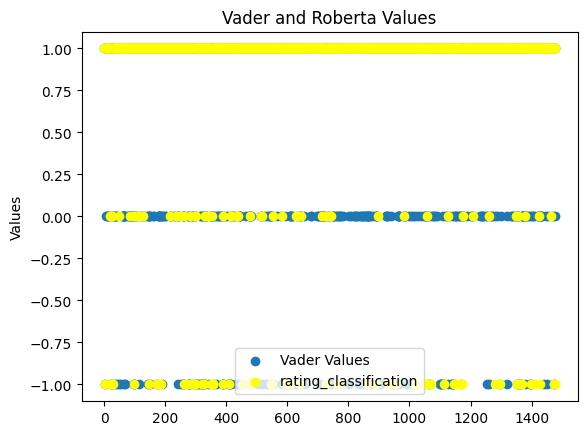

In [62]:
#Vader values vs rating
plt.scatter(df_vaders_roberta_sentiments.index, df_vaders_roberta_sentiments['vaders'], label='Vader Values')

plt.scatter(df_vaders_roberta_sentiments.index, df_vaders_roberta_sentiments['rating_classification'], color='yellow', label='rating_classification')

plt.xlabel('')
plt.ylabel('Values')
plt.title('Vader and rating classification')
plt.legend()  
plt.show()

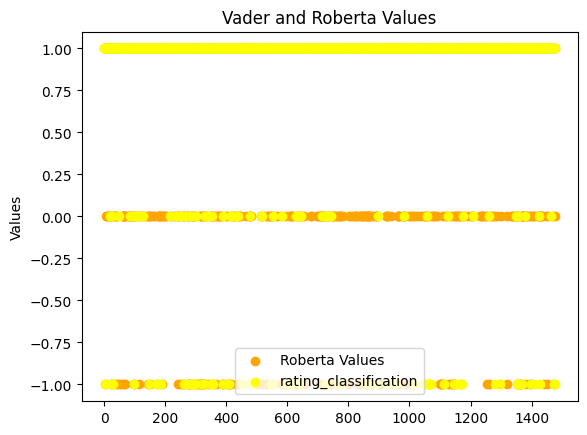

In [63]:
#RoBERTa values vs rating
plt.scatter(df_vaders_roberta_sentiments.index, df_vaders_roberta_sentiments['roberta'], color='orange', label='Roberta Values')
plt.scatter(df_vaders_roberta_sentiments.index, df_vaders_roberta_sentiments['rating_classification'], color='yellow', label='rating_classification')

plt.xlabel('')
plt.ylabel('Values')
plt.title('Roberta and rating classification Values')
plt.legend()  
plt.show()

In [ ]:
#both the models are working in the same way and classification by both is same , so we can choose any of the models for further analysis

Conclusion - analysis of the classification

In [79]:
#response of people from different countries
sentiment_counts = df_roberta.groupby(['country', 'sentiment']).size().reset_index(name='count')
sentiment_pivot = sentiment_counts.pivot(index='country', columns='sentiment', values='count')
sentiment_pivot.fillna(0, inplace=True)
total_reviews = sentiment_pivot.sum(axis=1)
# Calculate the percentage for each sentiment
sentiment_percentages = sentiment_pivot.divide(total_reviews, axis=0) * 100
total_reviews = sentiment_pivot.sum(axis=1)
sentiment_percentages['total_reviews'] = total_reviews
print(" Percentage of sentiment of the reviews from each country\n")
print(sentiment_percentages)

 Percentage of sentiment of the reviews from each country

sentiment            negative    neutral    positive  total_reviews
country                                                            
Australia           14.285714  21.428571   64.285714           14.0
Belgium             12.500000  12.500000   75.000000            8.0
Brazil               0.000000  19.047619   80.952381           42.0
Canada               5.405405  24.324324   70.270270          111.0
France               9.615385  18.269231   72.115385          104.0
Germany             11.904762  15.476190   72.619048           84.0
India               13.414634  28.048780   58.536585           82.0
Italy                6.060606  21.212121   72.727273           99.0
Japan                5.882353  36.470588   57.647059           85.0
Mexico               6.060606  19.696970   74.242424           66.0
Poland               0.000000   0.000000  100.000000            2.0
Singapore           18.181818   0.000000   81.818182     

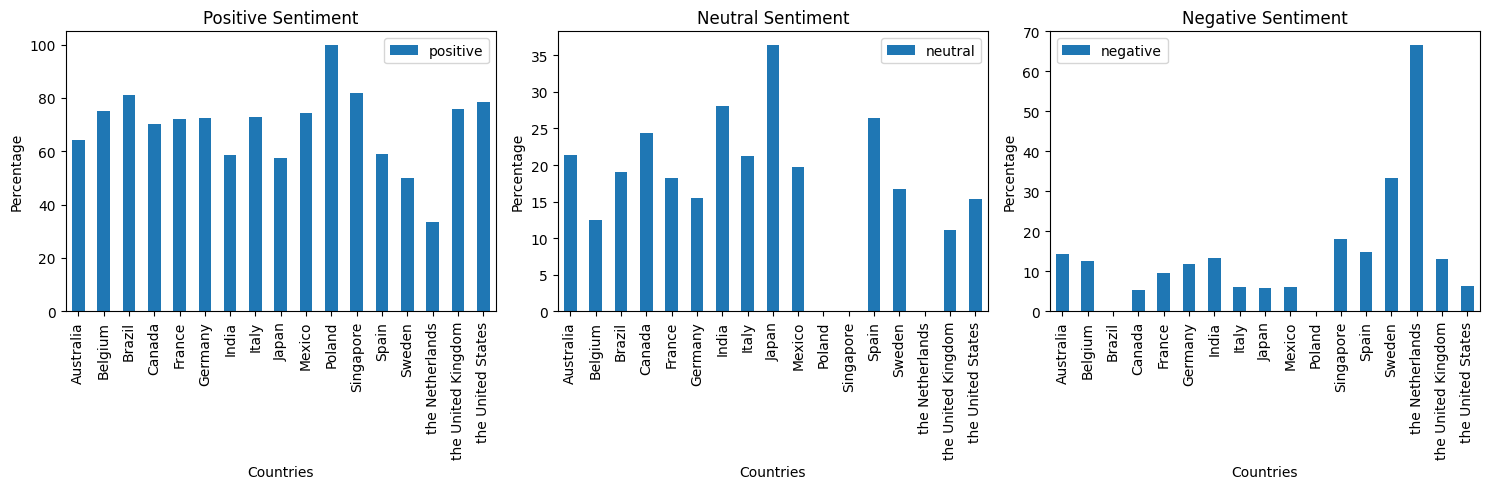

In [99]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot positive sentiment
sentiment_percentages.plot(kind='bar', y='positive', ax=axs[0])
axs[0].set_xlabel('Countries')
axs[0].set_ylabel('Percentage')
axs[0].set_title('Positive Sentiment')

# Plot neutral sentiment
sentiment_percentages.plot(kind='bar', y='neutral', ax=axs[1])
axs[1].set_xlabel('Countries')
axs[1].set_ylabel('Percentage')
axs[1].set_title('Neutral Sentiment')

# Hide the third subplot (empty)
sentiment_percentages.plot(kind='bar', y='negative', ax=axs[2])
axs[2].set_xlabel('Countries')
axs[2].set_ylabel('Percentage')
axs[2].set_title('Negative Sentiment')

# Show the plots
plt.tight_layout()
plt.show()

In [111]:
#summarizing the review of each product, and seeing which is has the most positive review

sentiment_counts = df_roberta.groupby(['product_id', 'sentiment']).size().reset_index(name='count')
sentiment_pivot = sentiment_counts.pivot(index='product_id', columns='sentiment', values='count')
sentiment_pivot.fillna(0, inplace=True)
total_reviews = sentiment_pivot.sum(axis=1)
# Calculate the percentage for each sentiment
sentiment_percentages = sentiment_pivot.divide(total_reviews, axis=0) * 100
total_reviews = sentiment_pivot.sum(axis=1)
sentiment_percentages['total_reviews'] = total_reviews
print(" Percentage of sentiment of the reviews for each product\n")
print(sentiment_percentages)

 Percentage of sentiment of the reviews for each product

sentiment    negative    neutral   positive  total_reviews
product_id                                                
11400F       6.172840  20.987654  72.839506           81.0
11700K       5.555556  22.222222  72.222222           90.0
11900K      17.777778  21.111111  61.111111           90.0
12100F      12.359551  17.977528  69.662921           89.0
12400        6.666667  13.333333  80.000000           90.0
12400F      10.112360  15.730337  74.157303           89.0
12600K       7.407407   9.876543  82.716049           81.0
12700        6.976744  27.906977  65.116279           43.0
12700K       2.222222  20.000000  77.777778           90.0
12900K       8.888889  21.111111  70.000000           90.0
13100        0.000000  33.333333  66.666667            9.0
13400F       4.201681  17.647059  78.151261          119.0
13500       12.096774  15.322581  72.580645          124.0
13600K       2.222222  14.444444  83.333333           90.

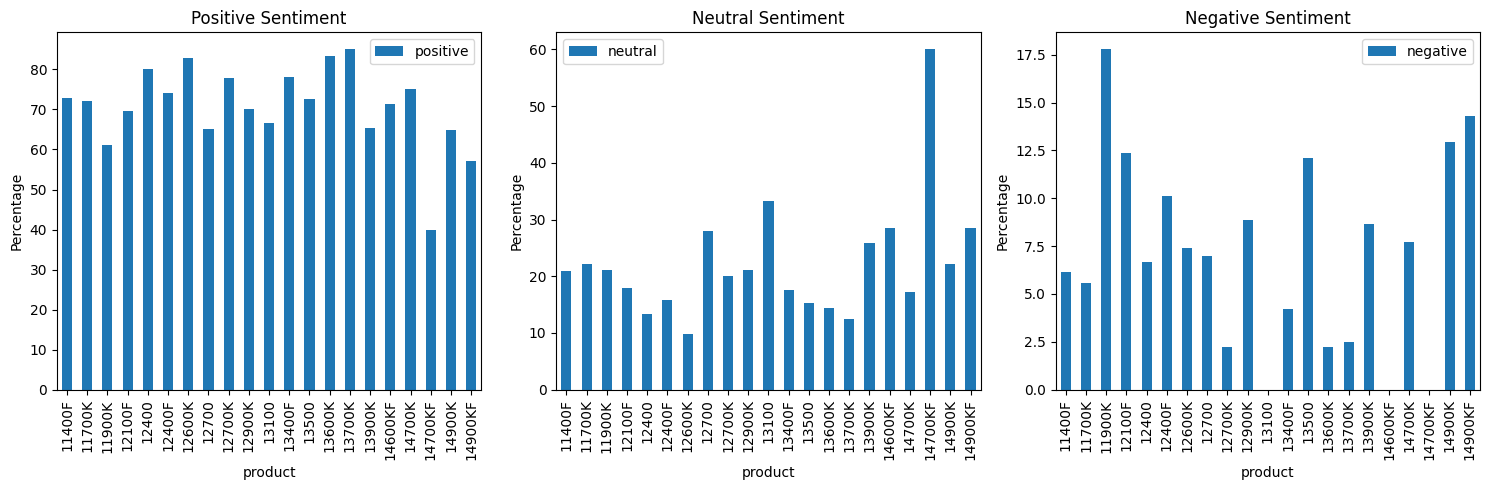

In [112]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot positive sentiment
sentiment_percentages.plot(kind='bar', y='positive', ax=axs[0])
axs[0].set_xlabel('product')
axs[0].set_ylabel('Percentage')
axs[0].set_title('Positive Sentiment')

# Plot neutral sentiment
sentiment_percentages.plot(kind='bar', y='neutral', ax=axs[1])
axs[1].set_xlabel('product')
axs[1].set_ylabel('Percentage')
axs[1].set_title('Neutral Sentiment')

# Hide the third subplot (empty)
sentiment_percentages.plot(kind='bar', y='negative', ax=axs[2])
axs[2].set_xlabel('product')
axs[2].set_ylabel('Percentage')
axs[2].set_title('Negative Sentiment')

# Show the plots
plt.tight_layout()
plt.show()

In [123]:
#sentiment of the product with respect to price of the product
df1= pd.DataFrame()
df1['review_sentiment']=df_vaders_roberta_sentiments['roberta']
df1['price']=df_roberta['mrp']
df1= df1.sort_values('price')
df1.reset_index(drop=True)

,review_sentiment,price
0,1,14500
1,1,14500
2,-1,14500
3,1,14500
4,-1,14500
...,...,...
1473,1,99999
1474,0,99999
1475,1,99999
1476,0,99999


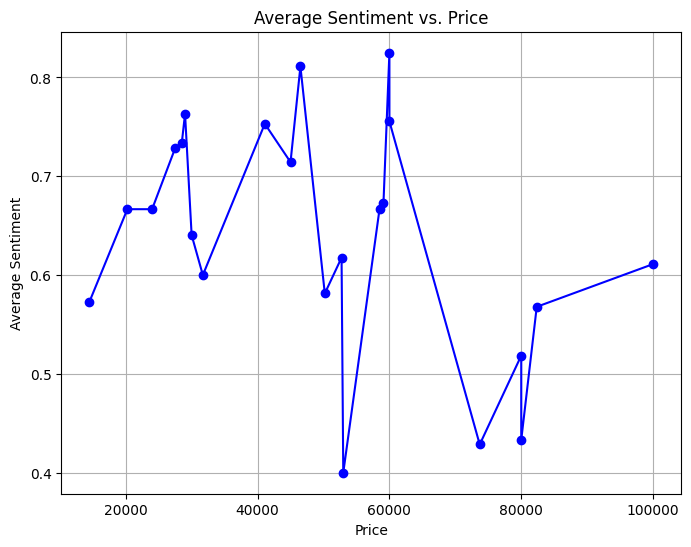

In [130]:
avg_sentiment = df1.groupby('price')['review_sentiment'].mean()
plt.figure(figsize=(8, 6))
plt.plot(avg_sentiment.index, avg_sentiment.values, marker='o', linestyle='-', color='b')
plt.xlabel('Price')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment vs. Price')
plt.grid(True)
plt.show()